# How to compute a Neural Adjoint Map

A neural adjoint map can be seen a functional map plus a non linear module. Given a correspondence, we can compute a neural adjoint map as we do for functional maps.

In [ ]:
import gs.backend as gs

from geomfum.dataset import NotebooksDataset
from geomfum.refine import NeuralZoomOut, ZoomOut
from geomfum.shape import TriangleMesh

In [ ]:
dataset = NotebooksDataset()

mesh_a = TriangleMesh.from_file(dataset.get_filename("cat-00"))
mesh_b = TriangleMesh.from_file(dataset.get_filename("lion-00"))

mesh_a.n_vertices, mesh_b.n_vertices

INFO: Data has already been downloaded... using cached file ('/home/ubuntu/.geomfum/data/cat-00.off').
INFO: Data has already been downloaded... using cached file ('/home/ubuntu/.geomfum/data/lion-00.off').


(7207, 5000)

In [ ]:
mesh_a.laplacian.find_spectrum(spectrum_size=50, set_as_basis=True)
mesh_b.laplacian.find_spectrum(spectrum_size=50, set_as_basis=True)

(array([1.37910516e-15, 1.08692580e+01, 1.81320950e+01, 2.90812660e+01,
        3.06173749e+01, 3.12651252e+01, 4.78481503e+01, 8.78504820e+01,
        1.40470146e+02, 1.47856194e+02, 1.49164759e+02, 1.72857180e+02,
        1.76642726e+02, 2.07807791e+02, 2.44858198e+02, 2.76816825e+02,
        3.00135675e+02, 3.01929992e+02, 3.31792544e+02, 3.76725198e+02,
        3.80675117e+02, 4.39189453e+02, 4.40434106e+02, 4.67869854e+02,
        5.01610789e+02, 5.41754796e+02, 5.51533782e+02, 5.68138789e+02,
        5.73241345e+02, 6.27962720e+02, 6.50075188e+02, 6.70621587e+02,
        6.82782441e+02, 7.11999556e+02, 7.42171097e+02, 7.76985084e+02,
        7.88552673e+02, 8.20376895e+02, 8.40174148e+02, 8.82438945e+02,
        9.01253188e+02, 9.05191559e+02, 9.40694542e+02, 9.67937725e+02,
        1.01222528e+03, 1.02144583e+03, 1.02531778e+03, 1.08542925e+03,
        1.11444708e+03, 1.15586949e+03]),
 array([[-1.35986867,  0.40090847, -0.41722911, ...,  0.39919736,
         -0.53062025,  1.638

We start by estimating a correspondence

In [ ]:
from geomfum.convert import NeighborFinder

neighbor_finder = NeighborFinder(n_neighbors=1)

p2p = neighbor_finder(mesh_b.vertices, mesh_a.vertices).flatten()

Then we convert it into a NAM

In [ ]:
from geomfum.convert import NamFromP2pConverter

mesh_a.basis.use_k = 10
mesh_b.basis.use_k = 10
nam_converter = NamFromP2pConverter(device="cpu")

nam = nam_converter(p2p, mesh_a.basis, mesh_b.basis)


In [ ]:
print(nam)

NeuralAdjointMap(
  (linear_module): Linear(in_features=10, out_features=10, bias=False)
  (nonlinear_module): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


We can visualize the linear part of the model

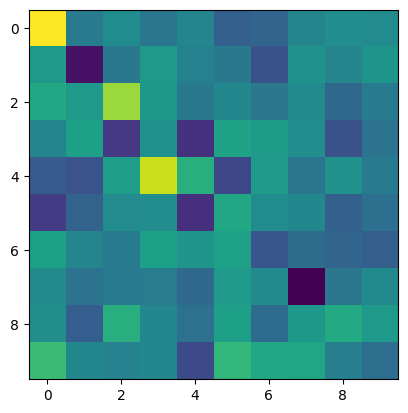

In [ ]:
import matplotlib.pyplot as plt

fmap = nam.linear_module.weight.detach().cpu().numpy()
plt.imshow(fmap)

Given a NAM, we can obtain a correspondence.

In [ ]:
from geomfum.convert import P2pFromNamConverter

p2p_from_nam = P2pFromNamConverter()

p2p = p2p_from_nam(nam, mesh_a.basis, mesh_b.basis)

As in ZoomOut, we can perform spectral upsampling on NAMS.

In [ ]:
nzo = NeuralZoomOut(nit=2, step=2, device="cpu")

nam_ref = nzo(nam, mesh_a.basis, mesh_b.basis)
